<a href="https://colab.research.google.com/github/GuilinXie/nanoGPT/blob/main/nanoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nanaGPT: A decoder-style Transformer,

In [1]:
import torch
import torch.nn as nn

## Masked single attention head

In [2]:
class Head(nn.Module):
  '''one head of self-attention'''
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size)
    self.query = nn.Linear(n_embd, head_size)
    self.value = nn.Linear(n_embd, head_size)
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)  #(B, T, head_size)
    q = self.query(x) #(B, T, head_size)
    v = self.value(x)  #(B, T, head_size)
    #compute attention scores("affinities")
    wei = q @ k.transpose(-2, -1) * (head_size ** (-0.5)) #(B, T, head_size) @ (B, head_size, T) = (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) #(B, T, T)
    wei = F.softmax(wei, dim=-1) #(B, T, T)
    wei = self.dropout(wei)
    #perform the weighted aggrergation of the values
    out = wei @ v # (B, T, T) @ (B, T, head_size) = (B, T, head_size)
    return out

## Maksed Multi-head Attention

In [3]:
class MultiHeadAttention(nn.Module):
  "multiple heads of self-attention in parallel"
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(num_heads * head_size, n_embd)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

## Position-wise Feed-Forward Networks

In [4]:
class FeedForward(nn.Module):
  '''computation'''
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout)
    )
  def forward(self, x):
    return self.net(x)

## Block: contains masked multi-head, feedforward, layernorm, and residual connection

In [5]:
class Block(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = self.sa(self.ln1(x)) + x
    x = self.ffwd(self.ln2(x)) + x
    return x

# The nanoGPT Model


In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class DecoderTransformerLM(nn.Module):
  '''Decoder Transformer Language Model'''
  def __init__(self):
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
      self.position_embedding_table = nn.Embedding(block_size, n_embd)
      self.block = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
      self.ln_f = nn.LayerNorm(n_embd)
      self.lm_head = nn.Linear(n_embd, vocab_size)
  def forward(self, idx, targets=None):
      B, T = idx.shape
      tok_emb = self.token_embedding_table(idx) #(B, T, C)
      pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
      x = tok_emb + pos_emb  #(B, T, C)
      self.block(x)
      logits = self.lm_head(x) #(B, T, vocab_size)
      loss = None
      if targets is not None:
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        targets = targets.view(B * T)
        loss = F.cross_entropy(logits, targets)
      return logits, loss

  def generate(self, idx, max_new_tokens):
      for _ in range(max_new_tokens):
        # crop idx to the las block_size tokens
        idx_cond = idx[:, -block_size:]
        logits, _ = self(idx_cond)
        logits = logits[:, -1, :] # (B, C)
        probs = F.softmax(logits, dim=1) # (B, C)
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        idx = torch.cat((idx, idx_next), dim=1)  #(B, T + 1)
      return idx

# Estimate loss
## At certain iteration, evaluate random batches, and get mean of the losses

In [7]:
@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ["train", "val"]:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      xb, yb = get_batch(split)
      xb = xb.to(device)
      yb = yb.to(device)
      _, loss = model(xb, yb)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

# Hyperparameters

In [16]:
torch.manual_seed(1337)
# hyperparameters
batch_size = 32
block_size = 64
max_iters = 5000
eval_interval = 200
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_head = 8
n_layer = 6
head_size = n_embd // n_head
dropout = 0.2

# Get input data

In [17]:
input_txt = "/content/drive/MyDrive/input.txt"
with open(input_txt, "r", encoding="utf-8") as f:
  text = f.read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join(itos[i] for i in l)
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# dataloader, get random data samples as batches
def get_batch(split):
  data = train_data if split == "train" else val_data
  ix = torch.randint(len(data) - block_size, (batch_size, ))
  x = torch.stack([data[i: i + block_size] for i in ix])
  y = torch.stack([data[i+1: i + block_size + 1] for i in ix])
  return x, y

xb, yb = get_batch("train")
xb = xb.to(device)
yb = yb.to(device)

# Train loop
## Initiate and train the model

In [18]:
%%time
model = DecoderTransformerLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses_train = {}
losses_val = {}
for iter in range(max_iters):
  if iter % eval_interval == 0:
    losses = estimate_loss()
    losses_train[iter] = losses['train']
    losses_val[iter] = losses['val']
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
  xb, yb = get_batch("train")
  xb = xb.to(device)
  yb = yb.to(device)
  logits, loss = model(xb, yb)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

step 0: train loss 4.4350, val loss 4.4455
step 200: train loss 2.7566, val loss 2.7741
step 400: train loss 2.5939, val loss 2.6140
step 600: train loss 2.5394, val loss 2.5538
step 800: train loss 2.5136, val loss 2.5260
step 1000: train loss 2.5047, val loss 2.5186
step 1200: train loss 2.4921, val loss 2.5037
step 1400: train loss 2.4848, val loss 2.5074
step 1600: train loss 2.4808, val loss 2.4997
step 1800: train loss 2.4779, val loss 2.5015
step 2000: train loss 2.4727, val loss 2.4963
step 2200: train loss 2.4728, val loss 2.4910
step 2400: train loss 2.4739, val loss 2.4936
step 2600: train loss 2.4701, val loss 2.4935
step 2800: train loss 2.4699, val loss 2.4930
step 3000: train loss 2.4686, val loss 2.4912
step 3200: train loss 2.4672, val loss 2.4861
step 3400: train loss 2.4664, val loss 2.4853
step 3600: train loss 2.4628, val loss 2.4880
step 3800: train loss 2.4665, val loss 2.4869
step 4000: train loss 2.4665, val loss 2.4873
step 4200: train loss 2.4676, val loss 2.

# Visualize val loss

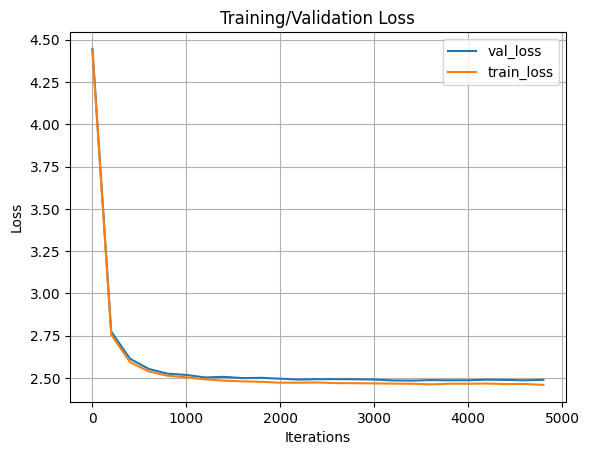

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses_val.keys(), losses_val.values(), label="val_loss")
plt.plot(losses_train.keys(), losses_train.values(), label="train_loss")
plt.legend()
plt.title("Training/Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.grid()

# Generate Shakespeare-like text

In [20]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


Bust fatondd manind th h
Mithon ay ifd,
And ttsthe use whrreave stil t he? if he.'t of br mays;

ARY t atheathatheet measoy wndive:
fo sm comerelley t e mort t'd wid yoflls hifly har couconice t, themat ase, t outou, t in tld fods
G cer hemyord five SAlang krdene d me;
LLULENGLUSAncthodll bring RWhesouthonee:
HE:
Obr kearoftheaind ms.
Greimbeld bel lp--heashe thay ye t IOROROUSAnth he wimo, w t tige aghee Mag fed pr ad con,

As cesigily,

I he hid thmy winglivercoctofo n m CLMis byo bobeglom.
Ma


In [21]:
print(sum(p.numel() for p in model.parameters()) / 1e3, "K parameters")

312.513 K parameters
